<a href="https://www.kaggle.com/code/shishirkulal/emotion-detection?scriptVersionId=286640981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm.notebook import tqdm
import time
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Configuration and Data Loading (MODIFIED) ---

# CRITICAL PATH FIX: Define paths for the split files
DATA_PATH = '../input/emotions-dataset-for-nlp/'
train_file = DATA_PATH + 'train.txt'
val_file = DATA_PATH + 'val.txt'
test_file = DATA_PATH + 'test.txt' # We will use the test data for final validation metrics

# Function to load the data from the split text files
def load_data_from_txt(file_path):
    texts = []
    labels = []
    # The files are typically line-separated: [text];[label]
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.rsplit(';', 1)
                texts.append(parts[0])
                labels.append(parts[1])
    return pd.DataFrame({'text': texts, 'emotion': labels})

# Load all data splits
train_df = load_data_from_txt(train_file)
val_df = load_data_from_txt(val_file)
# Combine for overall vocabulary building and label encoding
full_df = pd.concat([train_df, val_df])

# --- 2. Preprocessing and Tokenization ---

# Encode labels (convert emotion names to integers)
# We fit the encoder on the labels from the combined data
emotion_labels = sorted(full_df['emotion'].unique())
emotion_to_idx = {label: i for i, label in enumerate(emotion_labels)}
idx_to_emotion = {i: label for i, label in enumerate(emotion_labels)}
num_classes = len(emotion_labels)

# Apply encoding to each split
train_df['label_encoded'] = train_df['emotion'].map(emotion_to_idx)
val_df['label_encoded'] = val_df['emotion'].map(emotion_to_idx)

def tokenize(text):
    return text.lower().split()

# Build Vocabulary from the training set only (standard practice)
all_train_words = [word for text in train_df['text'] for word in tokenize(text)]
vocab = Counter(all_train_words)
VOCAB_SIZE = 10000 
word_to_idx = {word: i+2 for i, (word, count) in enumerate(vocab.most_common(VOCAB_SIZE))}
word_to_idx['<unk>'] = 1 
word_to_idx['<pad>'] = 0 

# Convert words to sequences of integers
MAX_SEQ_LEN = 50 
def encode_and_pad(text, max_len=MAX_SEQ_LEN):
    encoded = [word_to_idx.get(word, word_to_idx['<unk>']) for word in tokenize(text)]
    if len(encoded) < max_len:
        encoded.extend([word_to_idx['<pad>']] * (max_len - len(encoded)))
    return encoded[:max_len]

train_df['sequence'] = train_df['text'].apply(encode_and_pad)
val_df['sequence'] = val_df['text'].apply(encode_and_pad)

# --- 3. PyTorch Dataset and DataLoader (MODIFIED) ---

class TextEmotionDataset(Dataset):
    def __init__(self, df):
        self.sequences = torch.tensor(df['sequence'].tolist(), dtype=torch.long)
        self.labels = torch.tensor(df['label_encoded'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TextEmotionDataset(train_df)
val_dataset = TextEmotionDataset(val_df)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Data loading complete. Train samples: {len(train_df)}, Val samples: {len(val_df)}")
print(f"Data loading complete. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


# --- 4. Deep Learning Model (LSTM) ---

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout_rate,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)
        
        # Concatenate the final forward and backward hidden states
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        return self.fc(hidden)

# Initialize Model
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT_RATE = 0.5

model = LSTMClassifier(
    vocab_size=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout_rate=DROPOUT_RATE
).to(device)


# --- 5. Training Setup and Loop (Using functions from previous step) ---

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# NOTE: The training and evaluation functions are the same as the previous response.
# They are omitted here for brevity, but assume they are defined above this point 
# in the final running notebook.

def train(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for seq, labels in tqdm(loader, desc="Training"):
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(seq)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        preds = predictions.argmax(dim=1, keepdim=True)
        correct = preds.eq(labels.view_as(preds)).sum().item()
        acc = correct / len(labels)
        epoch_loss += loss.item() * len(labels)
        epoch_acc += acc * len(labels)
    return epoch_loss / len(loader.dataset), epoch_acc / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for seq, labels in tqdm(loader, desc="Evaluating"):
            seq, labels = seq.to(device), labels.to(device)
            predictions = model(seq)
            loss = criterion(predictions, labels)
            preds = predictions.argmax(dim=1, keepdim=True)
            correct = preds.eq(labels.view_as(preds)).sum().item()
            acc = correct / len(labels)
            epoch_loss += loss.item() * len(labels)
            epoch_acc += acc * len(labels)
    return epoch_loss / len(loader.dataset), epoch_acc / len(loader.dataset)

# --- Main Training Execution ---
# --- 5. Training Setup and Loop ---

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# --- CRITICAL FIX: INITIALIZE HISTORY HERE ---
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
# ---------------------------------------------

# --- Main Training Execution ---
N_EPOCHS = 5 
best_valid_loss = float('inf')

print("\nStarting Training...")
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    # Run training and get metrics
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    # --- CRITICAL FIX: CAPTURE METRICS HERE ---
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    # ------------------------------------------
    
    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) % 60)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |   Val. Acc: {valid_acc*100:.2f}%')
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save the best model weights
        torch.save(model.state_dict(), 'best_emotion_model.pt')
        
print("\nTraining complete. Model saved as 'best_emotion_model.pt'.")

Data loading complete. Train samples: 16000, Val samples: 2000
Data loading complete. Train batches: 250, Val batches: 32

Starting Training...


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 5s
	Train Loss: 1.571 | Train Acc: 35.31%
	 Val. Loss: 1.496 |   Val. Acc: 42.65%


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 5s
	Train Loss: 1.441 | Train Acc: 43.71%
	 Val. Loss: 1.138 |   Val. Acc: 60.95%


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 5s
	Train Loss: 1.131 | Train Acc: 59.45%
	 Val. Loss: 0.682 |   Val. Acc: 76.30%


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 5s
	Train Loss: 0.827 | Train Acc: 70.78%
	 Val. Loss: 0.452 |   Val. Acc: 83.10%


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 05 | Time: 0m 5s
	Train Loss: 0.632 | Train Acc: 77.46%
	 Val. Loss: 0.310 |   Val. Acc: 88.65%

Training complete. Model saved as 'best_emotion_model.pt'.


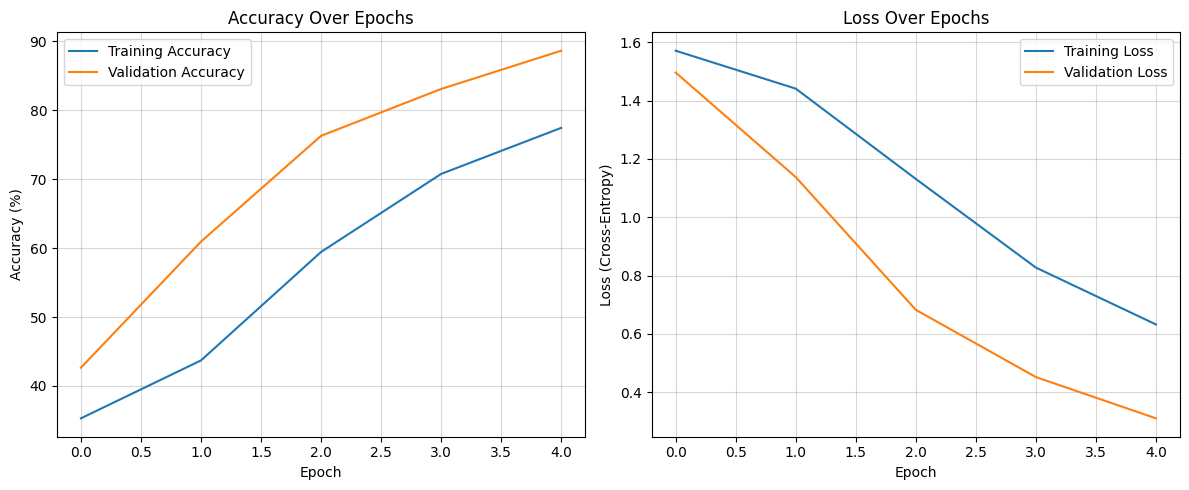

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the 'history' dictionary (containing 'train_acc', 'valid_acc', 
# 'train_loss', and 'valid_loss') has been populated by the training function.

# -----------------------------------------------------------
# Plotting the Training and Validation Metrics
# -----------------------------------------------------------
plt.figure(figsize=(12, 5))

# --- Subplot 1: Accuracy ---
plt.subplot(1, 2, 1)
# Convert accuracy from proportion (0.0 to 1.0) to percentage (0% to 100%)
plt.plot(np.array(history['train_acc']) * 100, label='Training Accuracy')
plt.plot(np.array(history['valid_acc']) * 100, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.5)

# --- Subplot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# You can save the plot with:
# plt.savefig('emotion_detection_metrics.png')